# **Catégoriser automatiquement des questions**
Stack Overflow est un site célèbre de questions-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags afin de retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Amateurs de Stack Overflow, qui nous a souvent sauvé la mise, nous décidons d'aider la communauté en retour. Pour cela, nous allons développer un système de suggestion de tags pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.

Stack Overflow propose un outil d’export de données, ["StackExchange Data Explorer"](https://data.stackexchange.com/stackoverflow/query/new), qui recense un grand nombre de données authentiques de la plateforme d’entraide. 

Pour récupérer le plus de résultats pertinents on va filtrer les quetions jugées les plus pertinentes, les plus vues, avec au moins 5 tags et ayant reçu une réponse à l'aide de la requête suivante: 
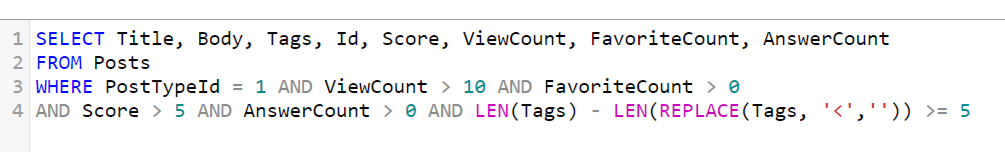



# **Sommaire**

*   **Partie 1:** <a href="#C1">Importation des données</a>
*   **Partie 2:** <a href="#C2">Nettoyage du jeu de données</a>
    * <a href="#C3">Valeurs manquantes</a>
    * <a href="#C4">Doublons</a>
    * <a href="#C5">Détection d'Outliers</a>
*   **Partie 3:** <a href="#C6">Feature Engineering</a>
    * <a href="#C7">Typage des questions</a>
    * <a href="#C8">Formatage des Tags</a>
    * <a href="#C9">Nettoyage du texte</a>
*   **Partie 4:** <a href="#C10">Exploration des données</a>
    * <a href="#C11">Nombre de mots dans les questions et les titres</a>
    * <a href="#C12">Fréquence des tags</a>
    * <a href="#C13">Corrélation des variables</a>
*   **Partie 5:** <a href="#C14">Exportation du jeu de données</a>






# <a name="C1">Partie 1: Imporation des données</a>
Commençons par importer les librairies utiles pour l'importation, le nettoyage et l'exploration des données.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import math
import pickle

from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from collections import defaultdict
from wordcloud import WordCloud
from PIL import Image
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
from joblib import dump, load

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

pd.set_option('display.max_columns', 100)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


On peut à présent charger les données.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/P5_BOURBON_Vicente/QueryResults.csv', sep=',',encoding='utf-8')
data.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,Best way to sign data in web form with user ce...,<p>We have a C# web app where users will conne...,<c#><javascript><asp.net-mvc><browser><x509cer...,3047437,9,6323,6,4
1,Google Test Fixtures,<p>I'm trying to understand how the Google Tes...,<c++><unit-testing><testing><googletest><test-...,3549540,22,45601,8,2
2,Autocomplete Textbox results based from SQL da...,<p>I'm trying to create an auto-complete funct...,<php><jquery><html><mysql><autocompletebox>,21298169,6,43604,5,5
3,What are the Steps to getting a Long Lasting T...,<p>I have a Business Page in Facebook (known a...,<facebook><facebook-graph-api><facebook-access...,18261813,15,13929,10,2
4,disk usage issue with rsync and --link-dest,<p>I have disk usage problem with <code>rsync<...,<linux><bash><shell><backup><rsync>,21298179,9,9030,4,3


In [ ]:
print('Le jeu de données est composé de', data.shape[0], 'lignes et ', data.shape[1], 'colonnes.')

Le jeu de données est composé de 50000 lignes et  8 colonnes.


# <a name="C2">Partie 2: Nettoyage du jeu de données</a>
Il nous faut maintenant contrôler et nettoyer le jeu de données avant de pouvoir l'explorer.
## <a name="C3">2.1: Valeurs manquantes</a>
Commençons par contôler les valeurs manquantes.

In [ ]:
def quantite_valeurs_manquantes(data):
    """fonction permettant d'obtenir le nombre et le pourcentage de valeurs manquantes pour chaque variable d'un dataframe, 
    dans l'ordre décroissant"""
    
    valeurs = data.isnull().sum()
    pourcentage = 100 * data.isnull().sum() / len(data)
    table = pd.concat([valeurs, pourcentage.round(2)], axis=1)
    table.columns = ['Nombre de valeurs manquantes', '% de valeurs manquantes']
    
    return table[table['Nombre de valeurs manquantes'] != 0].sort_values('% de valeurs manquantes', ascending = False).style.background_gradient('OrRd')

In [ ]:
quantite_valeurs_manquantes(data)

,Nombre de valeurs manquantes,% de valeurs manquantes


Il n'y a aucun trou dans le jeu de données, ce qui est plutôt rare !
## <a name="C4">2.2: Doublons</a>
Vérifions à présent qu'une même question n'apparaît pas deux fois.

In [ ]:
data.loc[data.duplicated()]

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount


Il n'y a aucune ligne identique mais cela ne garantit pas totalement l'abscence de doublons. Utilisons pour cela la variable `Id` qui permet d'identifier de manière unique une question.

In [ ]:
data.loc[data['Id'].duplicated()]

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount


In [ ]:
data.drop('Id', axis=1, inplace=True)
data.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,Best way to sign data in web form with user ce...,<p>We have a C# web app where users will conne...,<c#><javascript><asp.net-mvc><browser><x509cer...,3047437,9,6323,6,4
1,Google Test Fixtures,<p>I'm trying to understand how the Google Tes...,<c++><unit-testing><testing><googletest><test-...,3549540,22,45601,8,2
2,Autocomplete Textbox results based from SQL da...,<p>I'm trying to create an auto-complete funct...,<php><jquery><html><mysql><autocompletebox>,21298169,6,43604,5,5
3,What are the Steps to getting a Long Lasting T...,<p>I have a Business Page in Facebook (known a...,<facebook><facebook-graph-api><facebook-access...,18261813,15,13929,10,2
4,disk usage issue with rsync and --link-dest,<p>I have disk usage problem with <code>rsync<...,<linux><bash><shell><backup><rsync>,21298179,9,9030,4,3


Aucune répétition au niveau des identifiants, on peut raisonnablement considérer que le jeu de données est dépourvu de doublons et supprimer la variable `Id` qui ne nous servira plus.

## <a name="C5">2.3: Détection d'Outliers</a>
Un describe peut dans un premier temps nous être utile, notamment pour vérifier que les nombres de vues, favoris et réponses sont tous positifs ou nuls.

In [ ]:
data.describe()

,Id,Score,ViewCount,FavoriteCount,AnswerCount
count,5.000000e+04,50000.00000,5.000000e+04,50000.000000,50000.000000
mean,2.139012e+07,34.96754,3.355546e+04,12.031980,3.871880
std,1.823093e+07,195.65129,1.398265e+05,79.724964,4.051172
min,4.000000e+00,6.00000,5.100000e+01,1.000000,1.000000
25%,6.128266e+06,8.00000,3.664000e+03,2.000000,2.000000
50%,1.668590e+07,11.00000,9.646000e+03,3.000000,3.000000
75%,3.627086e+07,22.00000,2.495725e+04,7.000000,5.000000
max,7.193215e+07,19123.00000,9.841945e+06,6726.000000,121.000000


Les valeurs minimales sont non négatives et l'ensemble des valeurs semble assez cohérent avec le contexte. Considérons qu'il n'y a pas de valeurs aberrantes.
# <a name="C6">Partie 3: Feature Engineering</a>
Maintenant que le nettoyage est terminé et avant de l'explorer, on va repérer et préparer les caractéristiques intéressantes pour les modèles de machine learning que l'on utilisera par la suite.
## <a name="C7">3.1: Typage des questions</a>
Le premier problème que l'on rencontre est que le `Body` des questions est sauvegardé avec les balises HTML. On va ainsi supprimer ces balises ainsi que le code qui est parfois présent dans la question et ne récupérer que le texte.

In [ ]:
def suppression_html(text_html):
  """Fonction qui prend en entrée du texte au format html et qui renvoie uniquement le texte, dépourvu de touts les balises html"""
  soup = BeautifulSoup(text_html, features="html.parser")

  #On supprime les scipts et éléments de mise en page
  for script in soup(["script", "style"]):
      script.extract()

  #On récupère le texte
  text = soup.get_text()

  #On divise en lignes en supprimant les espaces
  lines = (line.strip() for line in text.splitlines())
  #Idem avec les titres
  chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
  #On supprime les lignes vides
  text = '\n'.join(chunk for chunk in chunks if chunk)

  return text

In [ ]:
#On peut à présent reformater les questions
data['Body'] = data['Body'].apply(suppression_html)
data.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,Best way to sign data in web form with user ce...,We have a C# web app where users will connect ...,<c#><javascript><asp.net-mvc><browser><x509cer...,3047437,9,6323,6,4
1,Google Test Fixtures,I'm trying to understand how the Google Test F...,<c++><unit-testing><testing><googletest><test-...,3549540,22,45601,8,2
2,Autocomplete Textbox results based from SQL da...,I'm trying to create an auto-complete function...,<php><jquery><html><mysql><autocompletebox>,21298169,6,43604,5,5
3,What are the Steps to getting a Long Lasting T...,I have a Business Page in Facebook (known as a...,<facebook><facebook-graph-api><facebook-access...,18261813,15,13929,10,2
4,disk usage issue with rsync and --link-dest,I have disk usage problem with rsync and --lin...,<linux><bash><shell><backup><rsync>,21298179,9,9030,4,3


## <a name="C8">3.2: Formatage des Tags</a>
Le deuxième point qui pose soucis est que la liste des tags contient des chevrons <>. On va donc les retirer pour faciliter l'exploitattion des tags.

In [ ]:
def liste_tags(chaine):
  """Fonction qui prend en entrée une liste sous forme de chaîne avec des séparations de la forme <> et qui renvoie la chaîne dépourvue
  des séparateurs"""

  chaine = chaine.replace('<', '')
  chaine = chaine.replace('>', ' ')

  return chaine

In [ ]:
#Formatage des Tags
data['Tags'] = data['Tags'].apply(liste_tags)
data.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,Best way to sign data in web form with user ce...,We have a C# web app where users will connect ...,c# javascript asp.net-mvc browser x509certific...,3047437,9,6323,6,4
1,Google Test Fixtures,I'm trying to understand how the Google Test F...,c++ unit-testing testing googletest test-fixture,3549540,22,45601,8,2
2,Autocomplete Textbox results based from SQL da...,I'm trying to create an auto-complete function...,php jquery html mysql autocompletebox,21298169,6,43604,5,5
3,What are the Steps to getting a Long Lasting T...,I have a Business Page in Facebook (known as a...,facebook facebook-graph-api facebook-access-to...,18261813,15,13929,10,2
4,disk usage issue with rsync and --link-dest,I have disk usage problem with rsync and --lin...,linux bash shell backup rsync,21298179,9,9030,4,3


## <a name="C9">3.3: Nettoyage du texte</a>
On va écrire les fonctions qui vont nous permettre de nettoyer le corpus de questions, avec pour première étape l'utilisation de la fonction word_tokenize (« tokenize » signifie « séparer par mot ») qui va nous permettre de décomposer les questions et les titres en tableaux de mots afin de pouvoir effectuer des opérations dessus.

In [ ]:
#Tokenization
def tokenizer_fct(sentence) :
  """Fonction qui prend en entrée une chaîne de caractères et renvoie la liste des tokens de cette chaîne"""

  sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
  word_tokens = word_tokenize(sentence_clean)
  return word_tokens

#Retirer les majuscules
def lower_start_fct(list_words):
  """Fonction qui prend en entrée une liste de chaînes et renvoie la liste de ces chaînes en lettres minuscules"""

  lw = [w.lower() for w in list_words]
  return lw

#Stop words
new = set(stopwords.words('english')) - set(STOP_WORDS)
stop_words = list(set(stopwords.words('english'))) + list(new) + list(set(string.punctuation))

#On sauvegarde la liste des stopwords
dump(stop_words, 'stop_words.joblib')
pickle.dump(stop_words, open('stop_words.pkl','wb'))

def stop_words_filter_fct(list_words):
  """Fonction qui prend en entrée une liste de chaînes et renvoie la liste de ces chaînes nettoyée des stopwords """

  filtered_words = [w for w in list_words if not w in stop_words]
  filtered_w = [w for w in filtered_words if ((len(w) > 3) or (w=='c'))] #on conserve 'c' car il s'agit d'un nom de langage informatique
  return filtered_w

#Lemmatizer (base d'un mot)
def lemmatizer_fct(list_words):
  """Fonction qui prend en entrée une liste de chaînes et renvoie la liste après lemmatization"""

  lemmatizer = WordNetLemmatizer()
  lem_w = [lemmatizer.lemmatize(w) for w in list_words]
  return lem_w

#Stemmer (racine d'un mot)
def stemmer_fct(list_words):
  """Fonction qui prend en entrée une liste de chaînes et renvoie la liste après racinisation"""

  stemmer = SnowballStemmer('english')
  stem_w = [stemmer.stem(w) for w in list_words]
  return stem_w

#Fonction de préparation du texte pour le bag of words avec lemmatisation
def transform_bow_lem_fct(text) :
    word_tokens = tokenizer_fct(text)
    sw = stop_words_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemmatizer_fct(lw) 
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

Regardons les résultats de ces différents traitements sur une phrase d'exemple.

In [ ]:
sentence = data['Body'][0]
print(sentence)

We have a C# web app where users will connect using a digital certificate stored in their browsers.
From the examples that we have seen, verifying their identity will be easy once we enable SSL, as we can access the fields in the certificate, using Request.ClientCertificate, to check the user's name.
We have also been requested, however, to sign the data sent by the user (a few simple fields and a binary file) so that we can prove, without doubt, which user entered each record in our database.
Our first thought was creating a small text signature including the fields (and, if possible, the md5 of the file) and encrypt it with the private key of the certificate, but...
As far as I know we can't access the private key of the certificate to sign the data, and I don't know if there is any way to sign the fields in the browser, or we have no other option than using a Java applet. And if it's the latter, how we would do it (Is there any open source applet we can use? Would it be better if we

In [ ]:
#On tokenize
sentence = tokenizer_fct(sentence)
print(sentence)

['We', 'have', 'a', 'C', 'web', 'app', 'where', 'users', 'will', 'connect', 'using', 'a', 'digital', 'certificate', 'stored', 'in', 'their', 'browsers', '.', 'From', 'the', 'examples', 'that', 'we', 'have', 'seen', ',', 'verifying', 'their', 'identity', 'will', 'be', 'easy', 'once', 'we', 'enable', 'SSL', ',', 'as', 'we', 'can', 'access', 'the', 'fields', 'in', 'the', 'certificate', ',', 'using', 'Request.ClientCertificate', ',', 'to', 'check', 'the', 'user', "'s", 'name', '.', 'We', 'have', 'also', 'been', 'requested', ',', 'however', ',', 'to', 'sign', 'the', 'data', 'sent', 'by', 'the', 'user', '(', 'a', 'few', 'simple', 'fields', 'and', 'a', 'binary', 'file', ')', 'so', 'that', 'we', 'can', 'prove', ',', 'without', 'doubt', ',', 'which', 'user', 'entered', 'each', 'record', 'in', 'our', 'database', '.', 'Our', 'first', 'thought', 'was', 'creating', 'a', 'small', 'text', 'signature', 'including', 'the', 'fields', '(', 'and', ',', 'if', 'possible', ',', 'the', 'md5', 'of', 'the', 'fi

La tokennisation sépare les mots un à un. On remarque que les éléments de ponctuation sont considérés comme des mots.

In [ ]:
#On supprime les majuscules
sentence = lower_start_fct(sentence)
print(sentence)

['we', 'have', 'a', 'c', 'web', 'app', 'where', 'users', 'will', 'connect', 'using', 'a', 'digital', 'certificate', 'stored', 'in', 'their', 'browsers', '.', 'from', 'the', 'examples', 'that', 'we', 'have', 'seen', ',', 'verifying', 'their', 'identity', 'will', 'be', 'easy', 'once', 'we', 'enable', 'ssl', ',', 'as', 'we', 'can', 'access', 'the', 'fields', 'in', 'the', 'certificate', ',', 'using', 'request.clientcertificate', ',', 'to', 'check', 'the', 'user', "'s", 'name', '.', 'we', 'have', 'also', 'been', 'requested', ',', 'however', ',', 'to', 'sign', 'the', 'data', 'sent', 'by', 'the', 'user', '(', 'a', 'few', 'simple', 'fields', 'and', 'a', 'binary', 'file', ')', 'so', 'that', 'we', 'can', 'prove', ',', 'without', 'doubt', ',', 'which', 'user', 'entered', 'each', 'record', 'in', 'our', 'database', '.', 'our', 'first', 'thought', 'was', 'creating', 'a', 'small', 'text', 'signature', 'including', 'the', 'fields', '(', 'and', ',', 'if', 'possible', ',', 'the', 'md5', 'of', 'the', 'fi

Les majuscules ont bien été remplacées par des minuscules, notamment en début de phrase. Cela permet de ne pas considérer comme différent un même mot écrit en minuscules puis en majuscules.

In [ ]:
#On supprime les stopwords
sentence = stop_words_filter_fct(sentence)
print(sentence)

['c', 'users', 'connect', 'using', 'digital', 'certificate', 'stored', 'browsers', 'examples', 'seen', 'verifying', 'identity', 'easy', 'enable', 'access', 'fields', 'certificate', 'using', 'request.clientcertificate', 'check', 'user', 'name', 'also', 'requested', 'however', 'sign', 'data', 'sent', 'user', 'simple', 'fields', 'binary', 'file', 'prove', 'without', 'doubt', 'user', 'entered', 'record', 'database', 'first', 'thought', 'creating', 'small', 'text', 'signature', 'including', 'fields', 'possible', 'file', 'encrypt', 'private', 'certificate', 'know', 'access', 'private', 'certificate', 'sign', 'data', 'know', 'sign', 'fields', 'browser', 'option', 'using', 'java', 'applet', 'latter', 'would', 'open', 'source', 'applet', 'would', 'better', 'create', 'course', 'would', 'better', 'sign', 'fields', 'received', 'server', 'using', 'data', 'access', 'user', 'certificate', 'info', 'best', 'solve', 'problem', 'would', 'appreciated']


Les mots les plus communs tels que `the`, `from` ou `we`, ainsi que la ponctuation ont été supprimés. Cela permet de ne pas polluer les données avec des mots qui n'apportent pas de sens et ne permettent pas de caractériser et différencier les questions entre elles.

In [ ]:
#On lemmatise
sentence_lem = lemmatizer_fct(sentence)
print(sentence_lem)

['c', 'user', 'connect', 'using', 'digital', 'certificate', 'stored', 'browser', 'example', 'seen', 'verifying', 'identity', 'easy', 'enable', 'access', 'field', 'certificate', 'using', 'request.clientcertificate', 'check', 'user', 'name', 'also', 'requested', 'however', 'sign', 'data', 'sent', 'user', 'simple', 'field', 'binary', 'file', 'prove', 'without', 'doubt', 'user', 'entered', 'record', 'database', 'first', 'thought', 'creating', 'small', 'text', 'signature', 'including', 'field', 'possible', 'file', 'encrypt', 'private', 'certificate', 'know', 'access', 'private', 'certificate', 'sign', 'data', 'know', 'sign', 'field', 'browser', 'option', 'using', 'java', 'applet', 'latter', 'would', 'open', 'source', 'applet', 'would', 'better', 'create', 'course', 'would', 'better', 'sign', 'field', 'received', 'server', 'using', 'data', 'access', 'user', 'certificate', 'info', 'best', 'solve', 'problem', 'would', 'appreciated']


La lemmatisation permet de récupérer la base d'un mot. La principale caratéristique est que le pluriel est transformé en singulier, et le féminin en masculin.

In [ ]:
#On racinise
sentence_stem = stemmer_fct(sentence)
print(sentence_stem)

['c', 'user', 'connect', 'use', 'digit', 'certif', 'store', 'browser', 'exampl', 'seen', 'verifi', 'ident', 'easi', 'enabl', 'access', 'field', 'certif', 'use', 'request.clientcertif', 'check', 'user', 'name', 'also', 'request', 'howev', 'sign', 'data', 'sent', 'user', 'simpl', 'field', 'binari', 'file', 'prove', 'without', 'doubt', 'user', 'enter', 'record', 'databas', 'first', 'thought', 'creat', 'small', 'text', 'signatur', 'includ', 'field', 'possibl', 'file', 'encrypt', 'privat', 'certif', 'know', 'access', 'privat', 'certif', 'sign', 'data', 'know', 'sign', 'field', 'browser', 'option', 'use', 'java', 'applet', 'latter', 'would', 'open', 'sourc', 'applet', 'would', 'better', 'creat', 'cours', 'would', 'better', 'sign', 'field', 'receiv', 'server', 'use', 'data', 'access', 'user', 'certif', 'info', 'best', 'solv', 'problem', 'would', 'appreci']


La racinisation permet de récupérer la racine d'un mot. 

# <a name="C10">Partie 4: Exploration des données</a>

Commençons par écrire les fonctions de comptage des mots

In [ ]:
#Première version qui compte le nombre total de mots
def freq_stats_corpora(variable):
  """Fonction qui prend en entrée le nom d'une variable et retourne un data frame augmenté du nombre total de mots dans chaque question 
  de la variable considérée"""
  df = data.copy()
  db = df[variable].to_dict()
  corpora = defaultdict(list)

  # Création d'un corpus de tokens par question
  for num_ligne, question in db.items():
    corpora[num_ligne] = lower_start_fct(tokenizer_fct(question)) 

  stats = dict()

  for k, v in corpora.items():
      stats[k] = {'total': len(v)} 
  
  df['total'] = (pd.DataFrame.from_dict(stats, orient='index'))['total']
        
  return df

#Deuxième version qui compte le nombre total de mots ainsi que le nombre de mots uniques
def freq_stats_corpora2(variable):
  """Fonction qui prend en entrée le nom d'une variable et retourne un data frame augmenté du nombre total de mots dans chaque question 
  de la variable considérée ainsi que du nombre de mots uniques"""
  df = data.copy()
  db = df[variable].to_dict()
  corpora = defaultdict(list)

  # Création d'un corpus de tokens par question
  for num_ligne, question in db.items():
    corpora[num_ligne] = lower_start_fct(tokenizer_fct(question)) 

  stats = dict()

  for k, v in corpora.items():
      stats[k] = {'total': len(v), 'unique': len(nltk.FreqDist(v).keys())} 
        
  df['total'] = (pd.DataFrame.from_dict(stats, orient='index'))['total']
  df['unique'] = (pd.DataFrame.from_dict(stats, orient='index'))['unique']

  return df

#Troisième version qui compte le nombre total de mots ainsi que le nombre de mots uniques après avoir supprimer les stopwords
def freq_stats_corpora3(variable):
  """Fonction qui prend en entrée le nom d'une variable et retourne un data frame augmenté du nombre total de mots dans chaque question 
  de la variable considérée ainsi que du nombre de mots uniques, après avoir supprimé les stopwords"""
  df = data.copy()
  db = df[variable].to_dict()
  corpora = defaultdict(list)

  # Création d'un corpus de tokens par question
  for num_ligne, question in db.items():
    tokens = lower_start_fct(tokenizer_fct(question)) 
    corpora[num_ligne] = stop_words_filter_fct(tokens)

  stats = dict()

  for k, v in corpora.items():
      stats[k] = {'total': len(v), 'unique': len(nltk.FreqDist(v).keys())} 
  
  df['total'] = (pd.DataFrame.from_dict(stats, orient='index'))['total']
  df['unique'] = (pd.DataFrame.from_dict(stats, orient='index'))['unique']
        
  return df

#Quatrième version qui ajoute la lemmatization
def freq_stats_corpora4(variable):
  """Fonction qui prend en entrée le nom d'une variable et retourne un data frame augmenté du nombre total de mots dans chaque question 
  de la variable considérée ainsi que du nombre de mots uniques, après lemmatisation"""
  df = data.copy()
  db = df[variable].to_dict()
  corpora = defaultdict(list)

  # Création d'un corpus de tokens par question
  for num_ligne, question in db.items():
    tokens = lower_start_fct(tokenizer_fct(question)) 
    filter = stop_words_filter_fct(tokens)
    corpora[num_ligne] = lemmatizer_fct(filter)

  stats = dict()

  for k, v in corpora.items():
      stats[k] = {'total': len(v), 'unique': len(nltk.FreqDist(v).keys())} 
  
  df['total'] = (pd.DataFrame.from_dict(stats, orient='index'))['total']
  df['unique'] = (pd.DataFrame.from_dict(stats, orient='index'))['unique']
        
  return df

#Cinquième version avec racinisation
def freq_stats_corpora5(variable):
  """Fonction qui prend en entrée le nom d'une variable et retourne un data frame augmenté du nombre total de mots dans chaque question 
  de la variable considérée ainsi que du nombre de mots uniques, après racinisation"""
  df = data.copy()
  db = df[variable].to_dict()
  corpora = defaultdict(list)

  # Création d'un corpus de tokens par question
  for num_ligne, question in db.items():
    tokens = lower_start_fct(tokenizer_fct(question)) 
    filter = stop_words_filter_fct(tokens)
    corpora[num_ligne] = stemmer_fct(filter)

  stats = dict()

  for k, v in corpora.items():
      stats[k] = {'total': len(v), 'unique': len(nltk.FreqDist(v).keys())} 
  
  df['total'] = (pd.DataFrame.from_dict(stats, orient='index'))['total']
  df['unique'] = (pd.DataFrame.from_dict(stats, orient='index'))['unique']
        
  return df

## <a name="C11">4.1: Nombre de mots dans les questions et les titres</a>
On commence par afficher les questions qui comporte le plus de mots.

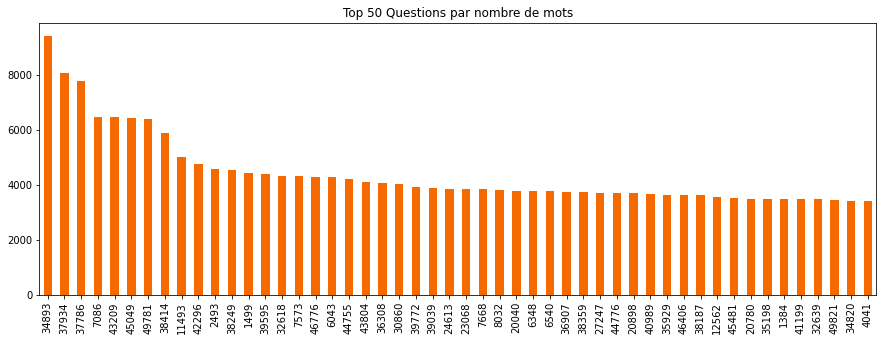

In [ ]:
#Récupération des comptages
df = pd.DataFrame()
df = freq_stats_corpora('Body')

# Affichage des fréquences
plt.rcParams["figure.figsize"] = [15, 5]
df.sort_values(by='total', ascending=False, inplace=True)
df['total'][:50].plot(kind='bar', color="#f56900", title='Top 50 Questions par nombre de mots')

On peut à présent se poser la question de la variété du vocabulaire, c'est à dire la quantité de mots différents utilisés dans une question.

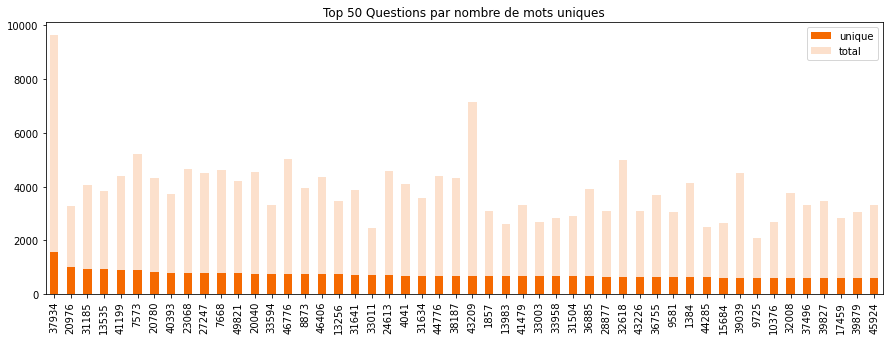

In [ ]:
#Récupération des comptages
df = pd.DataFrame()
df = freq_stats_corpora2('Body')

# Affichage des fréquences
plt.rcParams["figure.figsize"] = [15, 5]
df.sort_values(by='unique', ascending=False, inplace=True)
df[['unique', 'total']][:50].plot(kind='bar', color=["#f56900", "#fce0cc"], title='Top 50 Questions par nombre de mots uniques', stacked = True)

On remarque que l'ordre est complètement différent à présent.</br>
On peut alors se poser la question de savoir si l'emploi d'un grand nombre de mots uniques rend la question plus intelligible et conduit à plus de réponses.

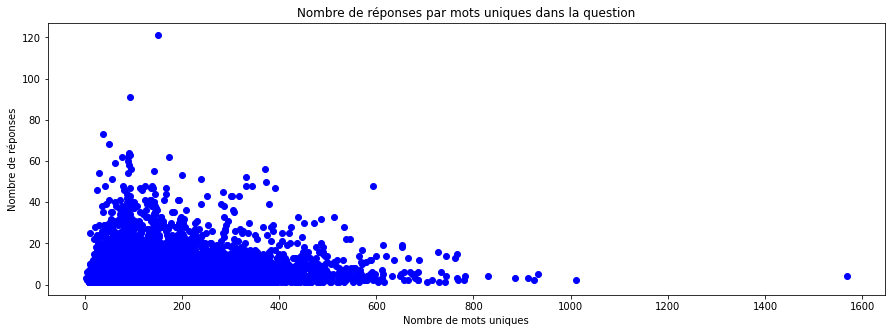

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df['unique'], data['AnswerCount'], 'bo')
plt.title('Nombre de réponses par mots uniques dans la question')
plt.xlabel('Nombre de mots uniques')
plt.ylabel('Nombre de réponses')
plt.show()

Le nombre de réponses ne semble pas augmenté lorsque la quantité de mots uniques augmente. Peut-être tout simplement car la question est plus précise et claire et donc une réponse est rapidement apportée. Regardons si au contraire un nombre de mots élévé tend à compliquer la question et produire plus de réponses.

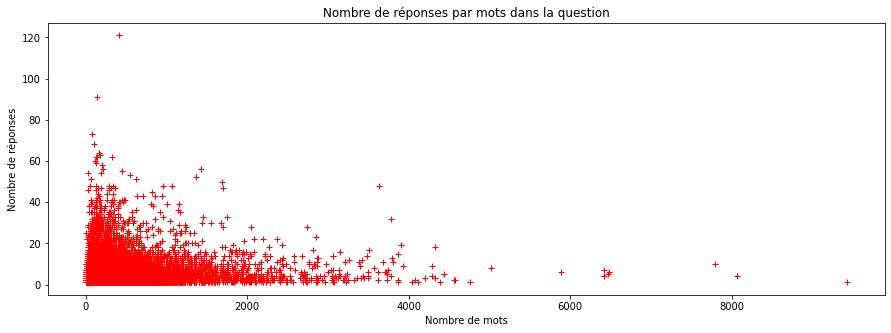

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df['total'], data['AnswerCount'], 'r+')
plt.title('Nombre de réponses par mots dans la question')
plt.xlabel('Nombre de mots')
plt.ylabel('Nombre de réponses')
plt.show()

On trouve des résultats assez similaires. Il ne semble pas y avoir de corrélation particulière entre le nombre de réponses et la quantité de mots (uniques) dans la question.</br>
Regardons à présent les quantités de mots dans les titres des questions.

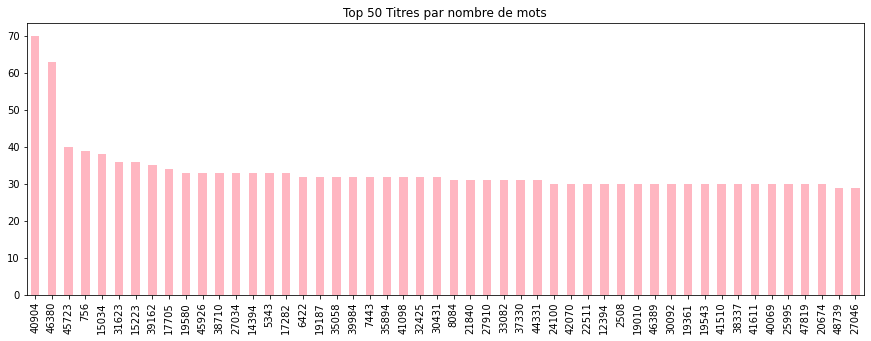

In [ ]:
#Récupération des comptages
df = pd.DataFrame()
df = freq_stats_corpora('Title')

# Affichage des fréquences
plt.rcParams["figure.figsize"] = [15, 5]
df.sort_values(by='total', ascending=False, inplace=True)
df['total'][:50].plot(kind='bar', color="#FFB6C1", title='Top 50 Titres par nombre de mots')

Il semble y avoir un peu moins de variabilité que pour les questions. Intéressons-nous à la quantité de mots uniques.

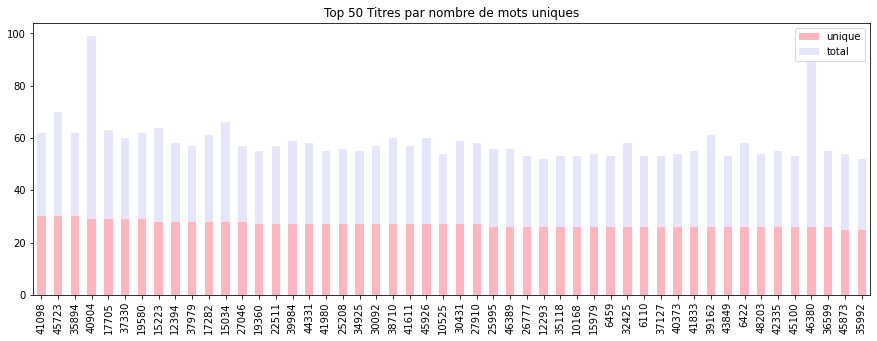

In [ ]:
#Récupération des comptages
df = pd.DataFrame()
df = freq_stats_corpora2('Title')

# Affichage des fréquences
plt.rcParams["figure.figsize"] = [15, 5]
df.sort_values(by='unique', ascending=False, inplace=True)
df[['unique', 'total']][:50].plot(kind='bar', color=["#FFB6C1", "#E6E6FA"], title='Top 50 Titres par nombre de mots uniques', stacked = True)

La proportion de mots uniques est beaucoup plus importante que pour les questions. Très certainement car les titres sont souvent une succession de mots clés, sans phrase et sans ponctuation.</br>
Allons-plus loin en supprimant les stopwords.

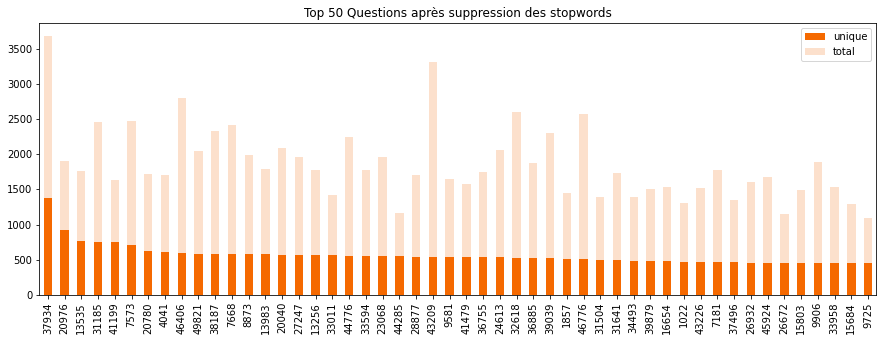

In [ ]:
#Récupération des comptages
df = pd.DataFrame()
df = freq_stats_corpora3('Body')

# Affichage des fréquences
plt.rcParams["figure.figsize"] = [15, 5]
df.sort_values(by='unique', ascending=False, inplace=True)
df[['unique', 'total']][:50].plot(kind='bar', color=["#f56900", "#fce0cc"], title='Top 50 Questions après suppression des stopwords', 
                                  stacked = True)

La proportion de mots uniques à logiquement augmenté après la suppression des stopwords.

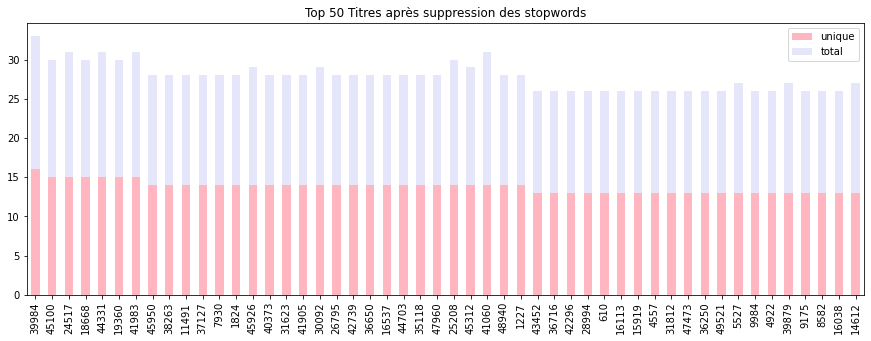

In [ ]:
#Récupération des comptages
df = pd.DataFrame()
df = freq_stats_corpora3('Title')

# Affichage des fréquences
plt.rcParams["figure.figsize"] = [15, 5]
df.sort_values(by='unique', ascending=False, inplace=True)
df[['unique', 'total']][:50].plot(kind='bar', color=["#FFB6C1", "#E6E6FA"], title='Top 50 Titres après suppression des stopwords', 
                                  stacked = True)

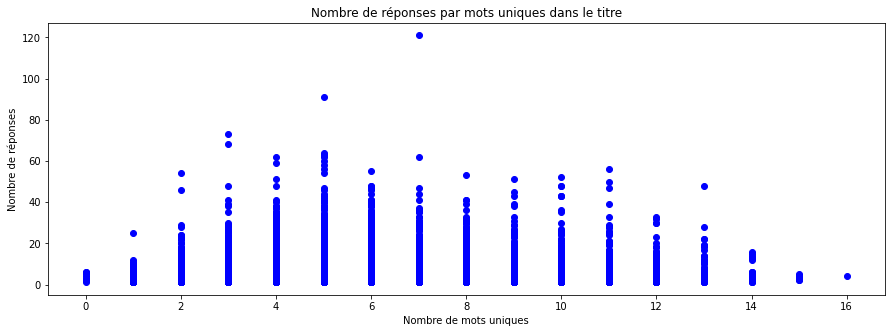

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df['unique'], data['AnswerCount'], 'bo')
plt.title('Nombre de réponses par mots uniques dans le titre')
plt.xlabel('Nombre de mots uniques')
plt.ylabel('Nombre de réponses')
plt.show()

Les résultats restent assez semblables au niveau des titres.</br>
Ajoutons en plus une lemmatisation, c'est à dire en ne conservant que la base des mots.

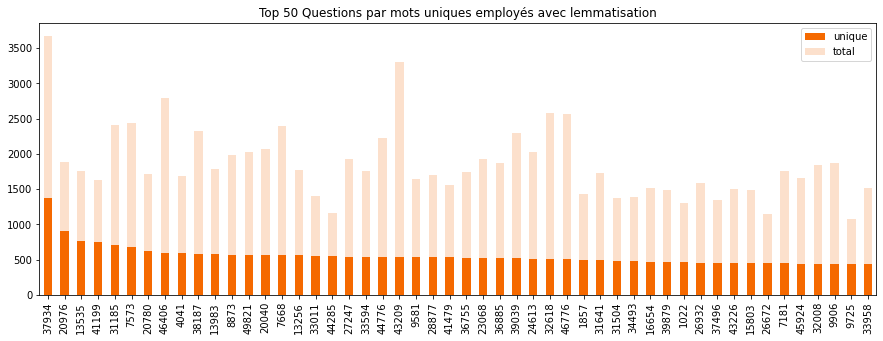

In [ ]:
#Récupération des comptages
df = pd.DataFrame()
df = freq_stats_corpora4('Body')

# Affichage des fréquences
plt.rcParams["figure.figsize"] = [15, 5]
df.sort_values(by='unique', ascending=False, inplace=True)
df[['unique', 'total']][:50].plot(kind='bar', color=["#f56900", "#fce0cc"], title='Top 50 Questions par mots uniques employés avec lemmatisation', 
                                  stacked = True)

Pas de différence très importante par rapport à la version précédente.

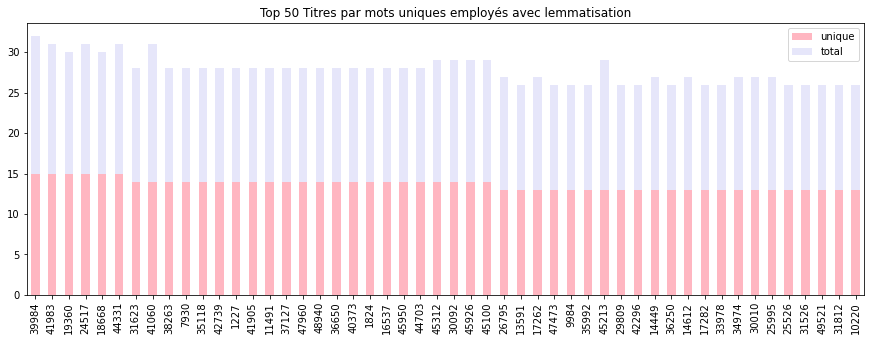

In [ ]:
#Récupération des comptages
df = pd.DataFrame()
df = freq_stats_corpora4('Title')

# Affichage des fréquences
plt.rcParams["figure.figsize"] = [15, 5]
df.sort_values(by='unique', ascending=False, inplace=True)
df[['unique', 'total']][:50].plot(kind='bar', color=["#FFB6C1", "#E6E6FA"], title='Top 50 Titres par mots uniques employés avec lemmatisation', 
                                  stacked = True)

La lemmatisation ne change pas considérablement les résultats. Essayons à la place la racinisation qui est une méthode plus complexe et plus intéressante dans l'extraction du sens des mots en ne conservant que la racine de ces derniers.

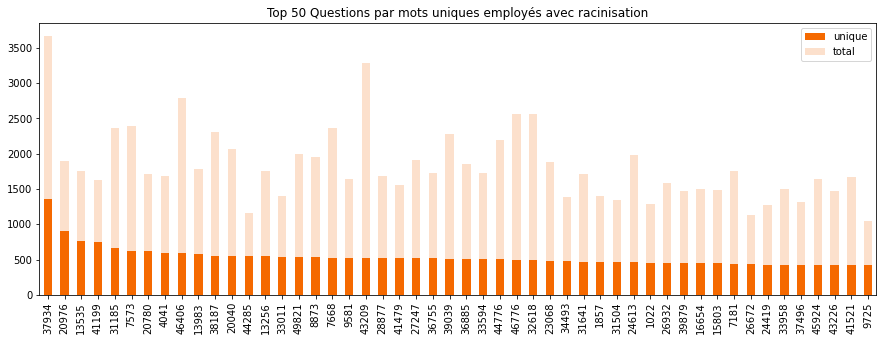

In [ ]:
#Récupération des comptages
df = pd.DataFrame()
df = freq_stats_corpora5('Body')

# Affichage des fréquences
plt.rcParams["figure.figsize"] = [15, 5]
df.sort_values(by='unique', ascending=False, inplace=True)
df[['unique', 'total']][:50].plot(kind='bar', color=["#f56900", "#fce0cc"], title='Top 50 Questions par mots uniques employés avec racinisation', 
                                  stacked = True)

Intéressons-nous aux mots les plus présents dans les questions une fois que la racinisation a été effectuée.

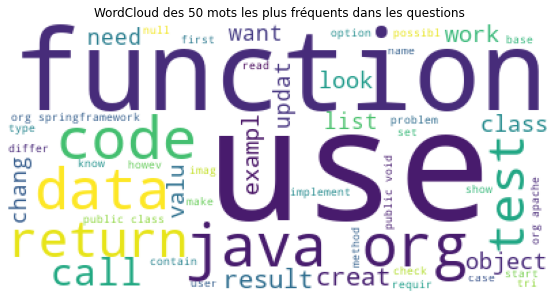

In [ ]:
## Fréquence d'apparition des mots dans les titres
w = df['Body']
w = w.apply(tokenizer_fct)
w = w.apply(lower_start_fct)
w = w.apply(stop_words_filter_fct)
w = w.apply(stemmer_fct)

#On récupère tous les tags en un seul texte pour faire un wordcloud
texte = ''
for liste in w:
  for chaine in liste:
    texte += chaine
    texte += ' '

plt.figure(figsize=(15,5))
wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(texte)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('WordCloud des 50 mots les plus fréquents dans les questions')
plt.show()

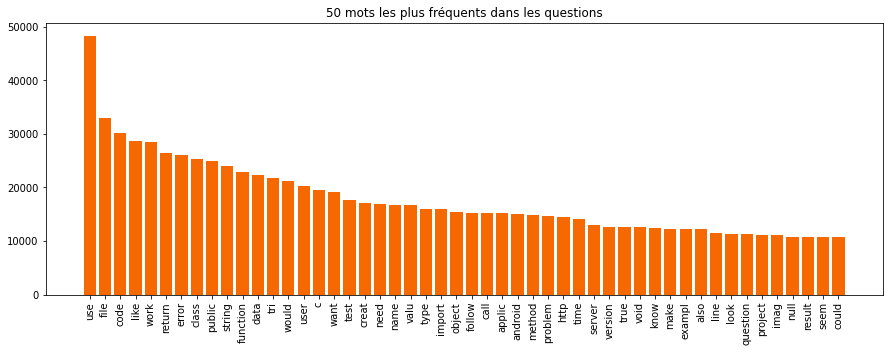

In [ ]:
#On récupère les fréquences de chaque mot pour un affichage sous forme d'histogramme
words = texte.split()
Word_dist = nltk.FreqDist(words)
res = pd.DataFrame(Word_dist.most_common(),columns=['Mots_Titre', 'Nb occurences'])

plt.rcParams["figure.figsize"] = [15, 5]
plt.bar('Mots_Titre', 'Nb occurences', data=res[:50], color=["#f56900"])
plt.xticks(rotation=90)
plt.title("50 mots les plus fréquents dans les questions")
plt.show()

On retrouve majoritairement des mots liés à l'informatique, ce qui est plutôt rassurant compte tenu du cadre et de la problématique de travail.</br>
Regardons de la même façon le processus de racinisation pour les titres.

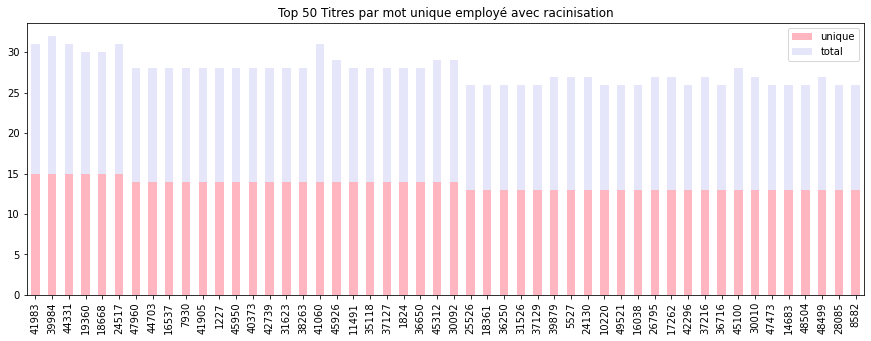

In [ ]:
#Récupération des comptages
df = pd.DataFrame()
df = freq_stats_corpora5('Title')

# Affichage des fréquences
plt.rcParams["figure.figsize"] = [15, 5]
df.sort_values(by='unique', ascending=False, inplace=True)
df[['unique', 'total']][:50].plot(kind='bar', color=["#FFB6C1", "#E6E6FA"], title='Top 50 Titres par mot unique employé avec racinisation', 
                                  stacked = True)

Regardons les mots qui apparaissent le plus souvent dans les titres une fois la racinisation effectuée.

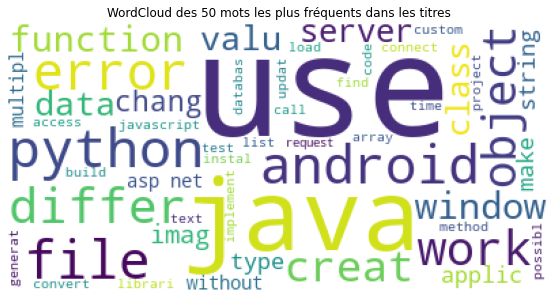

In [ ]:
## Fréquence d'apparition des mots dans les titres
w = df['Title']
w = w.apply(tokenizer_fct)
w = w.apply(lower_start_fct)
w = w.apply(stop_words_filter_fct)
w = w.apply(stemmer_fct)

#On récupère tous les tags en un seul texte pour faire un wordcloud
texte = ''
for liste in w:
  for chaine in liste:
    texte += chaine
    texte += ' '

plt.figure(figsize=(15,5))
wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(texte)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('WordCloud des 50 mots les plus fréquents dans les titres')
plt.show()

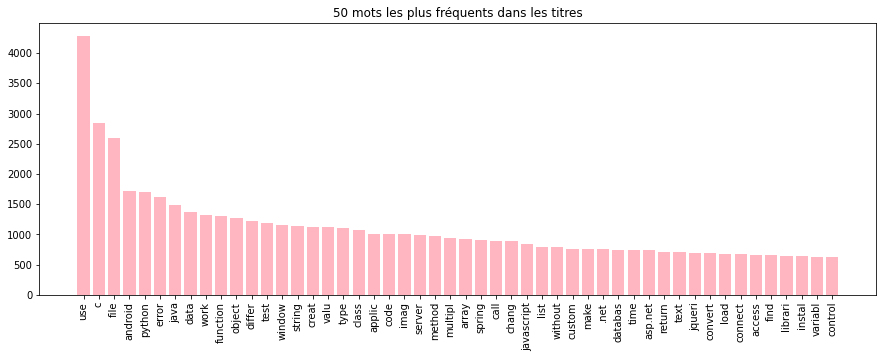

In [ ]:
#On récupère les fréquences de chaque mot pour un affichage sous forme d'histogramme
words = texte.split()
Word_dist = nltk.FreqDist(words)
res = pd.DataFrame(Word_dist.most_common(),columns=['Mots_Titre', 'Nb occurences'])

plt.rcParams["figure.figsize"] = [15, 5]
plt.bar('Mots_Titre', 'Nb occurences', data=res[:50], color=["#FFB6C1"])
plt.xticks(rotation=90)
plt.title("50 mots les plus fréquents dans les titres")
plt.show()

L'avantage des titres est qu'ils sont souvent dépourvus de verbes et contiennent davantage de mots essentiels, ce qui pourrait nous être particulièrement utile pour le système de suggestion de tags que l'on souhaite développer.

## <a name="C12">4.2: Fréquence des tags</a>
Pour bien poser une question sur le site **stackoverflow** il faut renseigner des tags. Dans notre requête initiale, nous n'avions sélectionné que des questions avec au moins 5 tags. Regardons si certaines questions en ont plus

Text(0.5, 1.0, 'Nombre de Tags par question')

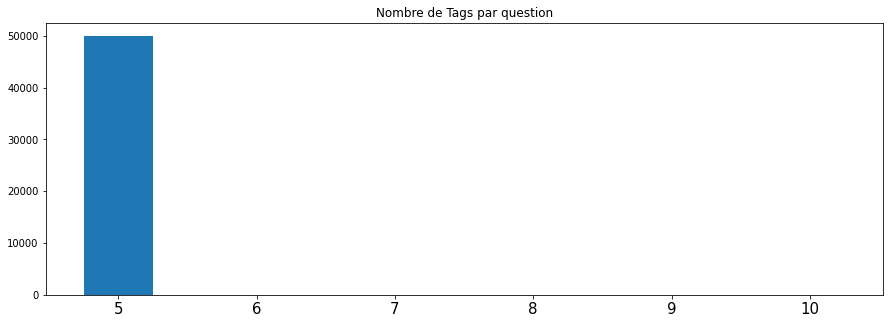

In [ ]:
X = data.apply(lambda row: len(row['Tags'].split()), axis=1)
plt.figure(figsize=(15,5))
plt.hist(X, bins = [4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], rwidth=0.5)
plt.xticks(fontsize=15)
plt.title('Nombre de Tags par question')

Toutes les questions sont bien renseignées avec 5 tags.</br>
On veut maintenant s'intéresser aux tags les plus présents. On peut pour cela les représenter sous forme de wordcloud, ou nuage de mots. Un mot sera d'autant plus présent dans le corpus qu'il apparaîtra gros sur le nuage de mots.

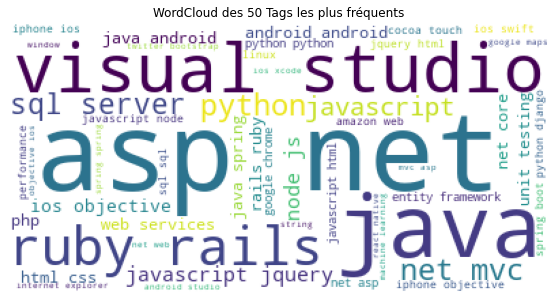

In [ ]:
#On récupère tous les tags en un seul texte pour faire un wordcloud
texte = ''
for chaine in data['Tags']:
  texte += chaine

plt.figure(figsize=(15,5))
wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(texte)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('WordCloud des 50 Tags les plus fréquents')
plt.show()

Les tags les plus utilisés sont `asp net`, `java`, `ruby rails`, `python` et `visual studio`.
## <a name="C13">4.3: Corrélation des variables</a>
Regardons s'il existe des corrélations entre les variables quantitatives.

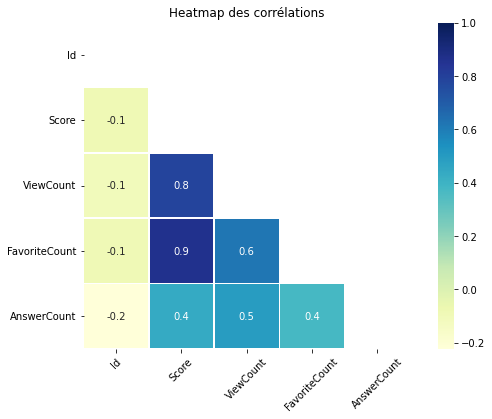

In [ ]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10, 6))
plt.xticks(rotation=45)
plt.title('Heatmap des corrélations')
sns.heatmap(corr, annot=True, cmap='YlGnBu', mask=mask, fmt='.1f', linewidths=.5, square=True, vmax=1)
plt.show()

On note une forte corrélation du nombre de vues et du nombres de favoris avec le score. En effectuant quelques recherches sur le fonctionnement de **stackoverflow** on comprend que le score d'un utilisateur est d'autant plus élevé que sa participation sur le site est importante, pertinente et utile. Il en découle une corrélation raisonnable entre la "popularité" d'un utilisateur et la visibilité de ses questions.

# <a name="C14">Partie 5: Exportation du jeu de données</a>



Les méthodes de modélisation qui seront utilisées par la suite étant parfois longue en terme de temps d'exécution on va dès à présent traiter et exporter les jeux d'entraînements et de tests afin de faciliter l'utilisation et la comparaison des modèles par la suite.</br>
On ne va conserver que le traitement avec lemmatisation, qui semble être le plus pertinent pour notre problématique, la racinisation risquant de créer des effets indésirables en transformant des mots spécifiques de l'informatique qui seront utilies pour la classification par la suite. 

In [ ]:
data['title_bow_lem'] = data['Title'].apply(lambda x : transform_bow_lem_fct(x))

data['body_bow_lem'] = data['Body'].apply(lambda x : transform_bow_lem_fct(x))

data.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,title_bow_lem,body_bow_lem
0,Best way to sign data in web form with user ce...,We have a C# web app where users will connect ...,c# javascript asp.net-mvc browser x509certific...,3047437,9,6323,6,4,best sign data form user certificate,user connect using digital certificate stored ...
1,Google Test Fixtures,I'm trying to understand how the Google Test F...,c++ unit-testing testing googletest test-fixture,3549540,22,45601,8,2,google test fixture,trying understand google test fixture work fol...
2,Autocomplete Textbox results based from SQL da...,I'm trying to create an auto-complete function...,php jquery html mysql autocompletebox,21298169,6,43604,5,5,autocomplete textbox result based database,trying create auto complete function textbox r...
3,What are the Steps to getting a Long Lasting T...,I have a Business Page in Facebook (known as a...,facebook facebook-graph-api facebook-access-to...,18261813,15,13929,10,2,what step getting long lasting token posting f...,business page facebook known page facebook ver...
4,disk usage issue with rsync and --link-dest,I have disk usage problem with rsync and --lin...,linux bash shell backup rsync,21298179,9,9030,4,3,disk usage issue rsync link dest,disk usage problem rsync link dest incremental...


In [ ]:
#Jeux d'entraînement et de test avec les titres
X_titles = data['title_bow_lem']
y = data['Tags']
X_train_titles, X_test_titles, y_train_titles, y_test_titles = train_test_split(X_titles, y, test_size = 0.2)

#Jeux d'entraînement et de test avec les questions
X_questions = data['body_bow_lem']
X_train_questions, X_test_questions, y_train_questions, y_test_questions = train_test_split(X_questions, y, test_size = 0.2)

In [ ]:
#Jeu complet nettoyé
data.to_csv('data_clean.csv', sep = ',', encoding='utf-8')

#Jeux d'entraînement et de test avec les titres
X_train_titles.to_csv('X_train_titles.csv', sep=',', encoding='utf-8')
X_test_titles.to_csv('X_test_titles.csv', sep=',', encoding='utf-8')
y_train_titles.to_csv('y_train_titles.csv', sep=',', encoding='utf-8')
y_test_titles.to_csv('y_test_titles.csv', sep=',', encoding='utf-8')

#Jeux d'entraînement et de test avec les questions
X_train_questions.to_csv('X_train_questions.csv', sep=',', encoding='utf-8')
X_test_questions.to_csv('X_test_questions.csv', sep=',', encoding='utf-8')
y_train_questions.to_csv('y_train_questions.csv', sep=',', encoding='utf-8')
y_test_questions.to_csv('y_test_questions.csv', sep=',', encoding='utf-8')